In [1]:
import sys
from collections import OrderedDict
from collections import defaultdict

import scipy.stats
import pandas as pd
import numpy as np

sys.path.insert(0, '/Users/timothyb0912/Documents/pylogit')
import pylogit as pl

sys.path.insert(0, '/Users/timothyb0912/Documents/stat241a/final_project/')
import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [2]:
car_df = pd.read_csv("../data/car_long_format.csv")

# Correct data errors

Note that the data from the R package 'mlogit' does not match the raw data taken from the journal of applied econometrics data archive. There was likely some error when converting from the format of the data in the archive (which is admittedly a strange format) to the data in mlogit.

Basically, 'electric' fuel type and 'methanol' fuel type appear to be switched.

In [3]:
exchange_dict = {'methanol': 'electric',
                 'electric': 'methanol',
                 'cng': 'cng',
                 'gasoline': 'gasoline'}

car_df['fuel_type'] = car_df['fuel_type'].map(exchange_dict)

# Create the necessary variables

#### Create variables from the original model

In [26]:
# Create the 'big_enough' variable
car_df['big_enough'] =\
    (car_df['hsg2'] & (car_df['vehicle_size'] == 3)).astype(int)

# Determine the type of car
car_df['sports_utility_vehicle'] =\
    (car_df['body_type'] == 'sportuv').astype(int)

car_df['sports_car'] =\
    (car_df['body_type'] == 'sportcar').astype(int)
    
car_df['station_wagon'] =\
    (car_df['body_type'] == 'stwagon').astype(int)

car_df['truck'] =\
    (car_df['body_type'] == 'truck').astype(int)

car_df['van'] =\
    (car_df['body_type'] == 'van').astype(int)

# Determine the car's fuel usage
car_df['electric'] =\
    (car_df['fuel_type'] == 'electric').astype(int)

car_df['compressed_natural_gas'] =\
    (car_df['fuel_type'] == 'cng').astype(int)

car_df['methanol'] =\
    (car_df['fuel_type'] == 'methanol').astype(int)

# Determine if this is an electric vehicle with a small commute
car_df['electric_commute_lte_5mi'] =\
    (car_df['electric'] & car_df['coml5']).astype(int)

# See if this is an electric vehicle for a college educated person
car_df['electric_and_college'] =\
    (car_df['electric'] & car_df['college']).astype(int)

# See if this is a methanol vehicle for a college educated person
car_df['methanol_and_college'] =\
    (car_df['methanol'] & car_df['college']).astype(int)
    
# Scale the range and acceleration variables
car_df['range_over_100'] = car_df['range'] / 100.0
car_df['acceleration_over_10'] = car_df['acceleration'] / 10.0
car_df['top_speed_over_100'] = car_df['top_speed'] / 100.0
car_df['vehicle_size_over_10'] = car_df['vehicle_size'] / 10.0
car_df['tens_of_cents_per_mile'] = car_df['cents_per_mile'] / 10.0

# Take the natural log of price/ln(income)
car_df['ln(price_over_log_income)'] =\
    np.log(car_df['price_over_log_income'])

#### Create variables for my new model

I need 3 things:
1. Interactions for the separate categories of body type with respect to all variables (save maybe luggage space)
2. Interactions for the separate categories of fuel type with respect to:
   1. price
   2. range
   3. top speed
   4. pollution
   5. operating costs
3. Piecewise linear specifications of:
   1. price
   2. range
   3. acceleration
   4. top speed
   5. pollution
   6. operating costs
4. Change specification of price to [x, ln(x)]

In [5]:
# Create interaction variables for the various body types
body_names = ['sports_utility_vehicle',
              'sports_car',
              'station_wagon',
              'truck',
              'van']

non_body_or_fuel_vars = ['price_over_log_income',
                         'ln(price_over_log_income)',
                         'range_over_100',
                         'acceleration_over_10',
                         'top_speed_over_100',
                         'pollution',
                         'vehicle_size_over_10',
                         'tens_of_cents_per_mile']

body_interactions = defaultdict(lambda : [])

for body in body_names:
    for interaction_var in non_body_or_fuel_vars:
        new_name = interaction_var + "_for_" + body
        # Store the new variable name
        body_interactions[interaction_var].append(new_name)
        # Create the data for the interaction variable
        car_df[new_name] =\
            car_df[body] * car_df[interaction_var]

In [6]:
# Create interaction variables for the various fuel types
fuel_names = ['electric',
              'compressed_natural_gas',
              'methanol']

fuel_interaction_vars = ['price_over_log_income',
                         'ln(price_over_log_income)',
                         'range_over_100',
                         'top_speed_over_100',
                         'pollution',
                         'vehicle_size_over_10',
                         'tens_of_cents_per_mile']

fuel_interactions = defaultdict(lambda : [])

for fuel in fuel_names:
    for interaction_var in fuel_interaction_vars:
        new_name = interaction_var + "_for_" + fuel
        # Store the new variable name
        fuel_interactions[interaction_var].append(new_name)
        # Create the data for the interaction variable
        car_df[new_name] =\
            car_df[fuel] * car_df[interaction_var]

In [20]:
interaction_mnl_spec, interaction_mnl_names = OrderedDict(), OrderedDict()

orig_cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in orig_cols_and_display_names:
    if col in body_interactions:
        for interaction_col in body_interactions[col]:
            suffix = interaction_col[interaction_col.rfind("for_") + 4:]
            new_display_name = display_name + " ({})".format(suffix)
            
            interaction_mnl_spec[interaction_col] = 'all_same'
            interaction_mnl_names[interaction_col] = new_display_name
            
#         for interaction_col in fuel_interactions[col]:
#             suffix = interaction_col[interaction_col.rfind("for_") + 4:]
#             new_display_name = display_name + "({})".format(suffix)
            
#             interaction_mnl_spec[interaction_col] = 'all_same'
#             interaction_mnl_names[interaction_col] = new_display_name

    interaction_mnl_spec[col] = 'all_same'
    interaction_mnl_names[col] = display_name


# Estimate the model with interactions.

In [21]:
# Initialize the mnl model
interaction_mnl = pl.create_choice_model(data=car_df,
                                         alt_id_col='alt_id',
                                         obs_id_col='obs_id',
                                         choice_col='choice',
                                         specification=interaction_mnl_spec,
                                         model_type='MNL',
                                         names=interaction_mnl_names)

# Create the initial variables for model estimation
num_vars = len(interaction_mnl_names)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = interaction_mnl.fit_mle(initial_vals,
                           method='L-BFGS-B',
                           just_point=True)['x']
interaction_mnl.fit_mle(initial_vals, method='BFGS')

# Look at the estimation results
interaction_mnl.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -8,338.8486
Estimation Time for Point Estimation: 0.87 seconds.
Final log-likelihood: -7,339.5969


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,598
Method:                                MLE   Df Model:                           56
Date:                     Mon, 15 Jan 2018   Pseudo R-squ.:                   0.120
Time:                             13:52:27   Pseudo R-bar-squ.:               0.113
AIC:                            14,791.194   Log-Likelihood:             -7,339.597
BIC:                            15,152.141   LL-Null:                    -8,338.849
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
Price over log(income) (sports_utility_vehicle)           0.2654      0.063      4.187      0.000         0.141     0.390
Price over log(income) (sports_car)                       0.1658      0.065      2.542      0.011         0.038     0.294
Price over log(income) (station_wagon)                   -0.1035      0.036     -2.902      0.004        -0.173    -0.034
Price over log(income) (truck)                           -0.0577      0.027     -2.154      0.031        -0.110    -0.005
Price over log(income) (van)                             -0.0834      0.027     -3.093      0.002        -0.136    -0.031
Price over log(income)                                   -0.1877      0.029     -6.520      0.000        -0.244    -0.131
Range (units: 100mi) (sports_utility_vehicle)            -0.0936      0.100     -0.937      0.349        -0.290     0.102
Range (units: 100mi) (sports_car)                        -0.0792      0.117     -0.678      0.498        -0.308     0.150
Range (units: 100mi) (station_wagon)                     -0.0893      0.085     -1.046      0.295        -0.257     0.078
Range (units: 100mi) (truck)                              0.0056      0.070      0.080      0.936        -0.131     0.142
Range (units: 100mi) (van)                                0.0651      0.067      0.976      0.329        -0.066     0.196
Range (units: 100mi)                                      0.3545      0.033     10.833      0.000         0.290     0.419
Acceleration (units: 0.1sec) (sports_utility_vehicle)    -0.1803      0.497     -0.363      0.717        -1.154     0.793
Acceleration (units: 0.1sec) (sports_car)                -0.9920      0.599     -1.655      0.098        -2.167     0.183
Acceleration (units: 0.1sec) (station_wagon)             -0.3337      0.445     -0.749      0.454        -1.207     0.539
Acceleration (units: 0.1sec) (truck)                     -0.1304      0.360     -0.362      0.717        -0.837     0.576
Acceleration (units: 0.1sec) (van)                       -0.6260      0.322     -1.946      0.052        -1.257     0.005
Acceleration (units: 0.1sec)                             -0.5455      0.145     -3.760      0.000        -0.830    -0.261
Top speed (units: 0.01mph) (sports_utility_vehicle)      -0.1059      0.329     -0.322      0.747        -0.750     0.538
Top speed (units: 0.01mph) (sports_car)                   0.2758      0.393      0.702      0.483        -0.494     1.046
Top speed (units: 0.01mph) (station_wagon)                0.1534      0.279      0.551      0.582        -0.393     0.699
Top speed (units: 0.01mph) (truck)                        0.1174      0.223      0.527      0.598        -0.319     0.554
Top speed (units: 0.01mph) (van)                         -0.0254      0.215     -0.118      0.906        -0.448     0.397
Top speed (units: 0.01mp

# Check the interaction model

In [23]:
# Simulate values from the sampling distribution of coefficients
interaction_sampling_dist =\
    scipy.stats.multivariate_normal(mean=interaction_mnl.params.values,
                                    cov=interaction_mnl.cov)
# Take Draws from the sampling distribution
num_draws = 500
simulated_coefs = interaction_sampling_dist.rvs(num_draws)
simulated_coefs.shape

(500, 56)

In [24]:
# Predict the model probabilities
simulated_probs =\
    interaction_mnl.predict(car_df,
                    param_list=[simulated_coefs.T, None, None, None])

# Simulate y from the sampling distribution
likelihood_sim_y =\
    viz.simulate_choice_vector(simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 8878.49it/s]


## Look at the price variable

Calculating CDFs: 100%|██████████| 100/100 [00:00<00:00, 291.69it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 194.58it/s]


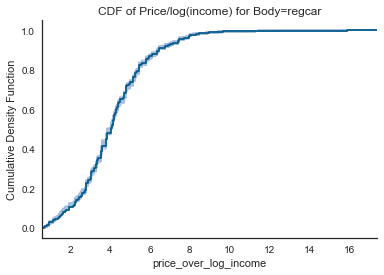

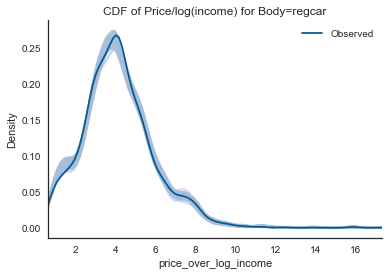

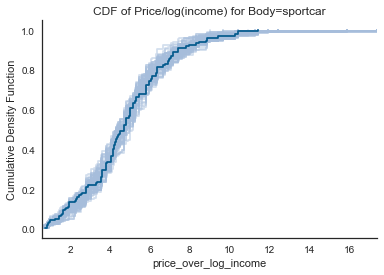

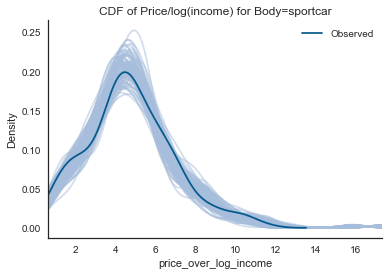

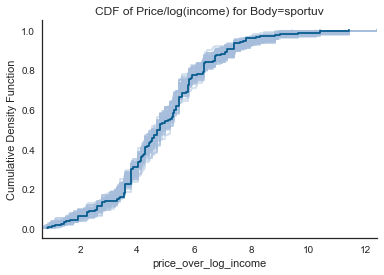

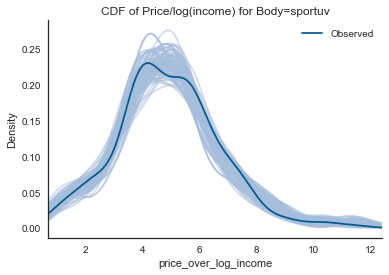

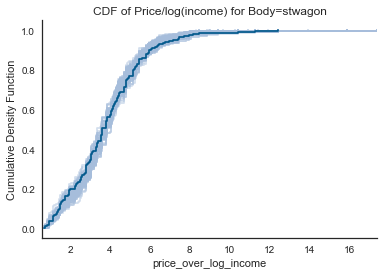

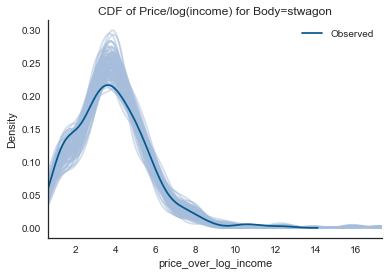

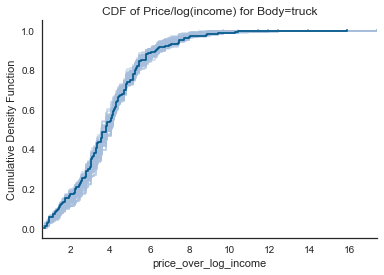

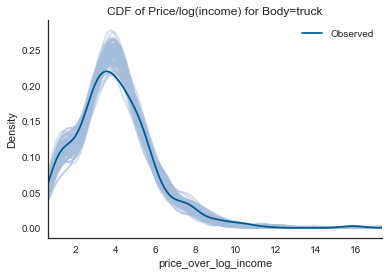

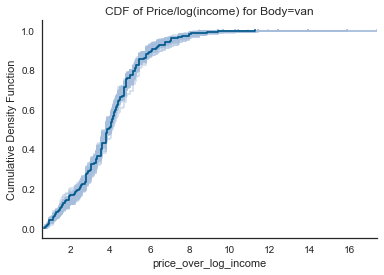

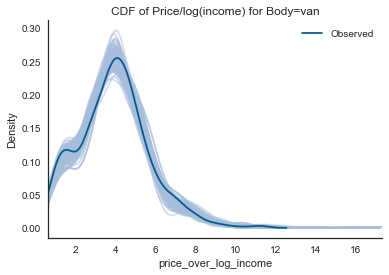

In [25]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    

There still exist problems with the price variable. Next I will try adding the natural log of price over log(income).

In [27]:
interaction_mnl_spec_2, interaction_mnl_names_2 = OrderedDict(), OrderedDict()

new_cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('ln(price_over_log_income)', 'ln(Price over log(income))'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in new_cols_and_display_names:
    if col in body_interactions:
        for interaction_col in body_interactions[col]:
            suffix = interaction_col[interaction_col.rfind("for_") + 4:]
            new_display_name = display_name + " ({})".format(suffix)
            
            interaction_mnl_spec_2[interaction_col] = 'all_same'
            interaction_mnl_names_2[interaction_col] = new_display_name
            
#         for interaction_col in fuel_interactions[col]:
#             suffix = interaction_col[interaction_col.rfind("for_") + 4:]
#             new_display_name = display_name + "({})".format(suffix)
            
#             interaction_mnl_spec[interaction_col] = 'all_same'
#             interaction_mnl_names[interaction_col] = new_display_name

    interaction_mnl_spec_2[col] = 'all_same'
    interaction_mnl_names_2[col] = display_name


In [29]:
# Initialize the mnl model
interaction_mnl_2 = pl.create_choice_model(data=car_df,
                                         alt_id_col='alt_id',
                                         obs_id_col='obs_id',
                                         choice_col='choice',
                                         specification=interaction_mnl_spec_2,
                                         model_type='MNL',
                                         names=interaction_mnl_names_2)

# Create the initial variables for model estimation
num_vars_2 = len(interaction_mnl_names_2)
initial_vals_2 = np.zeros(num_vars_2)

# Estimate the mnl model
fit_vals_2 = interaction_mnl_2.fit_mle(initial_vals_2,
                                       method='L-BFGS-B',
                                       just_point=True)['x']
interaction_mnl_2.fit_mle(initial_vals_2, method='BFGS')

# Look at the estimation results
interaction_mnl_2.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -8,338.8486
Estimation Time for Point Estimation: 0.51 seconds.
Final log-likelihood: -7,338.2978


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,597
Method:                                MLE   Df Model:                           57
Date:                     Mon, 15 Jan 2018   Pseudo R-squ.:                   0.120
Time:                             13:59:51   Pseudo R-bar-squ.:               0.113
AIC:                            14,790.596   Log-Likelihood:             -7,338.298
BIC:                            15,157.988   LL-Null:                    -8,338.849
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
Price over log(income) (sports_utility_vehicle)           0.2593      0.063      4.096      0.000         0.135     0.383
Price over log(income) (sports_car)                       0.1590      0.065      2.441      0.015         0.031     0.287
Price over log(income) (station_wagon)                   -0.1013      0.035     -2.856      0.004        -0.171    -0.032
Price over log(income) (truck)                           -0.0570      0.027     -2.139      0.032        -0.109    -0.005
Price over log(income) (van)                             -0.0825      0.027     -3.071      0.002        -0.135    -0.030
Price over log(income)                                   -0.1026      0.060     -1.707      0.088        -0.220     0.015
ln(Price over log(income))                               -0.3786      0.235     -1.612      0.107        -0.839     0.082
Range (units: 100mi) (sports_utility_vehicle)            -0.0937      0.100     -0.937      0.349        -0.290     0.102
Range (units: 100mi) (sports_car)                        -0.0790      0.117     -0.676      0.499        -0.308     0.150
Range (units: 100mi) (station_wagon)                     -0.0885      0.085     -1.037      0.300        -0.256     0.079
Range (units: 100mi) (truck)                              0.0050      0.070      0.071      0.943        -0.132     0.142
Range (units: 100mi) (van)                                0.0640      0.067      0.960      0.337        -0.067     0.195
Range (units: 100mi)                                      0.3550      0.033     10.845      0.000         0.291     0.419
Acceleration (units: 0.1sec) (sports_utility_vehicle)    -0.1820      0.497     -0.366      0.714        -1.156     0.792
Acceleration (units: 0.1sec) (sports_car)                -0.9933      0.599     -1.657      0.097        -2.168     0.181
Acceleration (units: 0.1sec) (station_wagon)             -0.3337      0.445     -0.750      0.454        -1.206     0.539
Acceleration (units: 0.1sec) (truck)                     -0.1337      0.360     -0.371      0.711        -0.840     0.573
Acceleration (units: 0.1sec) (van)                       -0.6301      0.322     -1.959      0.050        -1.261     0.000
Acceleration (units: 0.1sec)                             -0.5414      0.145     -3.731      0.000        -0.826    -0.257
Top speed (units: 0.01mph) (sports_utility_vehicle)      -0.1065      0.329     -0.324      0.746        -0.751     0.538
Top speed (units: 0.01mph) (sports_car)                   0.2740      0.393      0.697      0.486        -0.496     1.044
Top speed (units: 0.01mph) (station_wagon)                0.1567      0.279      0.563      0.574        -0.389     0.703
Top speed (units: 0.01mph) (truck)                        0.1169      0.223      0.525      0.600        -0.320     0.553
Top speed (units: 0.01mp

# Check the interaction model

In [30]:
# Simulate values from the sampling distribution of coefficients
interaction_sampling_dist_2 =\
    scipy.stats.multivariate_normal(mean=interaction_mnl_2.params.values,
                                    cov=interaction_mnl_2.cov)
# Take Draws from the sampling distribution
num_draws = 500
simulated_coefs_2 = interaction_sampling_dist_2.rvs(num_draws)
simulated_coefs_2.shape

# Predict the model probabilities
simulated_probs_2 =\
    interaction_mnl_2.predict(car_df,
                    param_list=[simulated_coefs_2.T, None, None, None])

# Simulate y from the sampling distribution
likelihood_sim_y_2 =\
    viz.simulate_choice_vector(simulated_probs_2,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 8773.45it/s]


Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 196.42it/s]


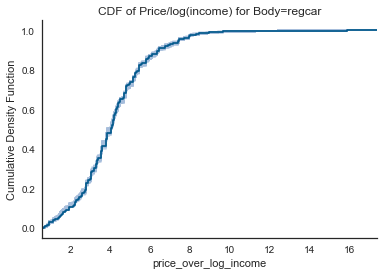

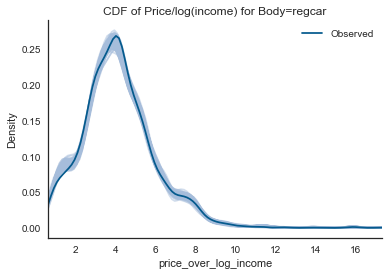

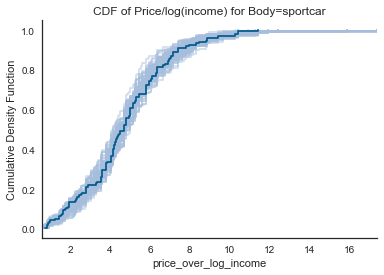

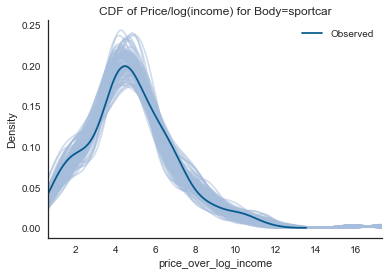

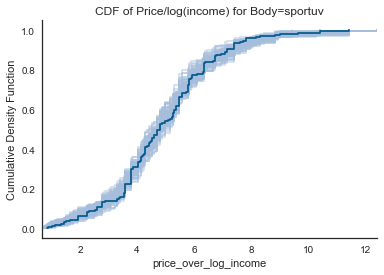

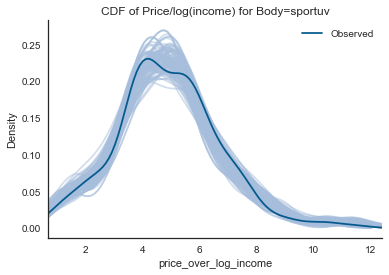

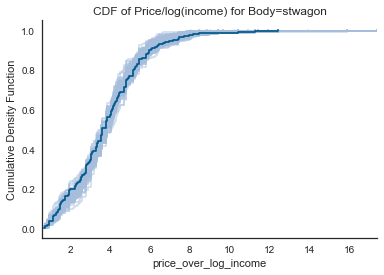

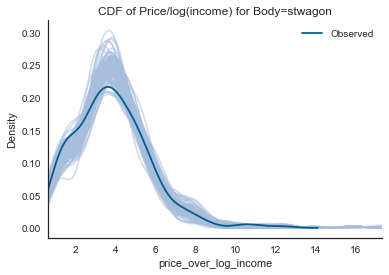

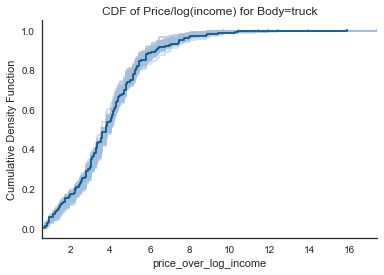

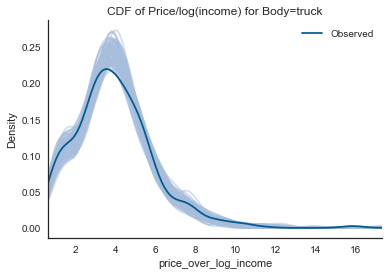

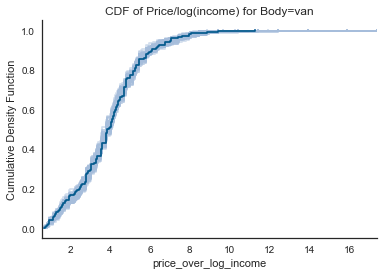

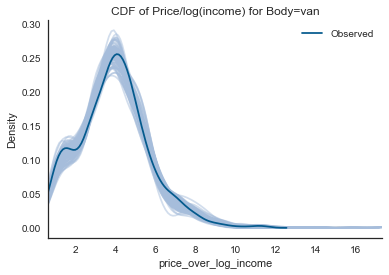

In [31]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(likelihood_sim_y_2,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(likelihood_sim_y_2,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    

# Try Bayesian version of an interaction mnl with body and fuel interactions

In [32]:
import theano_mnl

In [33]:
interaction_mnl_spec_full, interaction_mnl_names_full = OrderedDict(), OrderedDict()

orig_cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in orig_cols_and_display_names:
    if col in body_interactions:
        for interaction_col in body_interactions[col]:
            suffix = interaction_col[interaction_col.rfind("for_") + 4:]
            new_display_name = display_name + " ({})".format(suffix)
            
            interaction_mnl_spec_full[interaction_col] = 'all_same'
            interaction_mnl_names_full[interaction_col] = new_display_name
            
        for interaction_col in fuel_interactions[col]:
            suffix = interaction_col[interaction_col.rfind("for_") + 4:]
            new_display_name = display_name + "({})".format(suffix)
            
            interaction_mnl_spec_full[interaction_col] = 'all_same'
            interaction_mnl_names_full[interaction_col] = new_display_name

    interaction_mnl_spec_full[col] = 'all_same'
    interaction_mnl_names_full[col] = display_name


In [34]:
# Determine the number of index coefficients for the full interaction MNL
num_index_coefs_full = len(interaction_mnl_names_full)
# Create the prior variances.
normal_prior_variances_full = 4 * np.ones(num_index_coefs_full)

# Initialize the full interaction mnl model object
interaction_model_full =\
    pl.create_choice_model(data=car_df,
                           alt_id_col='alt_id',
                           obs_id_col='obs_id',
                           choice_col='choice',
                           specification=interaction_mnl_spec_full,
                           model_type='MNL',
                           names=interaction_mnl_names_full)

# Initialize the bayesian full interaction mnl model
bayes_mnl = theano_mnl.BayesMNL(car_df,
                                "alt_id",
                                "obs_id",
                                "choice",
                                interaction_mnl_spec_full,
                                interaction_mnl_names_full,
                                normal_prior_variances_full)

# Maximize the log-posterior
bayes_mnl.maximize_log_posterior()

# Set up the parameters for the posterior sampling
num_samples = 4000
num_segments = 50000
random_seed = 515
init_scale = 1.25
results_folder = None

# Perform the posterior sampling using scalable
# rejection sampling
posterior_sampling_results =\
    bayes_mnl.posterior_sampling(num_samples,
                                 num_segments,
                                 random_seed,
                                 init_scale,
                                 results_folder,
                                 describe=False)

# Calculate the predicted probabilities for each alternative of each observation
chosen_posterior_probs_2d, long_posterior_probs_2d =\
    interaction_model_full.predict(
                      car_df,
                      param_list=[posterior_sampling_results['samples'].T, None, None, None],
                      return_long_probs=True,
                      choice_col='choice')

# Get posterior simulations of y
posterior_simulated_y =\
    viz.simulate_choice_vector(long_posterior_probs_2d,
                           car_df['obs_id'].values)


Trying scale_factor == 1.25

Beginning registration process for proposal distribution
Sampling points from proposal distribution.
Calculating log-posterior values at sampled points.
Calculating log of the proposal density at sampled points.
count    50000.000000
mean        -9.172943
std          1.595311
min        -18.125479
1%         -13.383870
5%         -11.953843
10%        -11.258847
20%        -10.477100
25%        -10.183011
30%         -9.929132
40%         -9.472984
50%         -9.066885
60%         -8.677075
70%         -8.257453
75%         -8.046743
80%         -7.806949
90%         -7.225215
95%         -6.744867
99%         -5.931333
max         -4.268314
dtype: float64
Finished registering the proposal distribution.

scale_factor == 1.25


Posterior Sampling: 100%|██████████| 4000/4000 [06:05<00:00, 10.94it/s]


NameError: name 'simulate_choice_vector' is not defined

In [35]:
posterior_simulated_y =\
    viz.simulate_choice_vector(long_posterior_probs_2d,
                           car_df['obs_id'].values)

Simulating Choices: 100%|██████████| 4654/4654 [00:03<00:00, 1388.61it/s]


# Check the bayesian full interaction model

Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 197.69it/s]


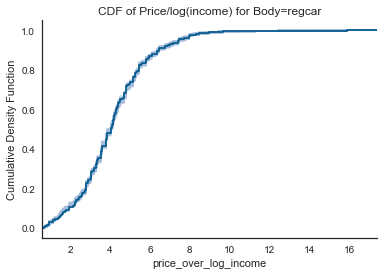

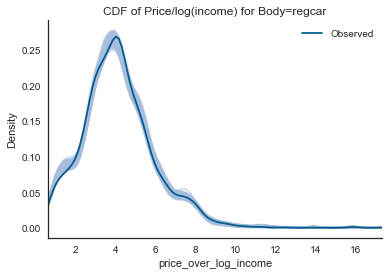

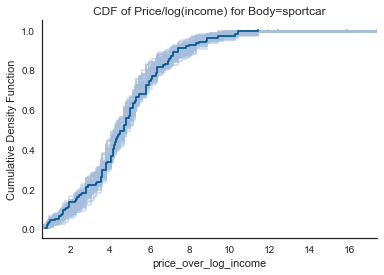

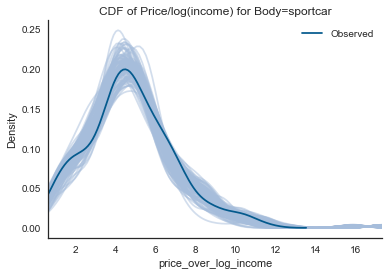

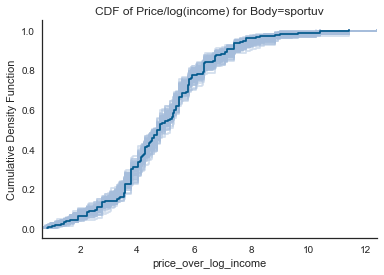

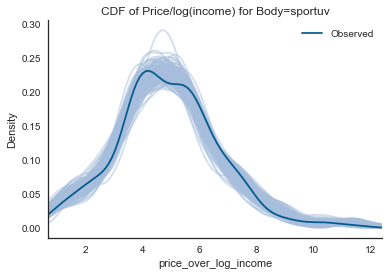

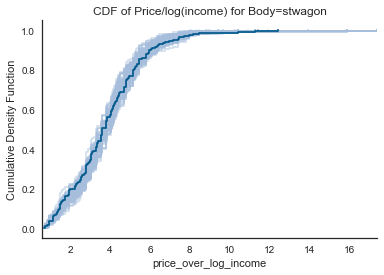

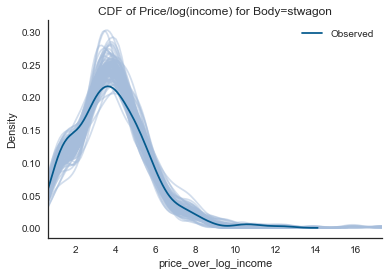

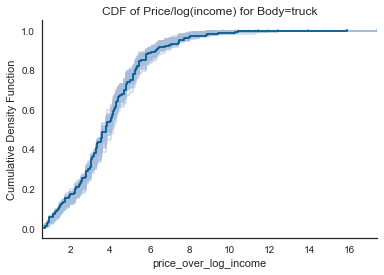

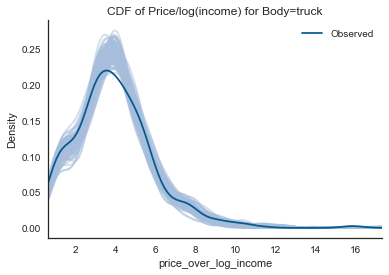

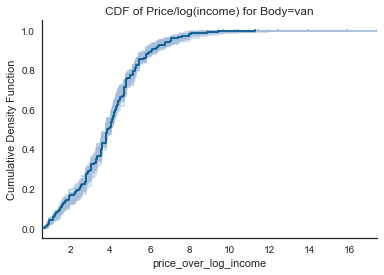

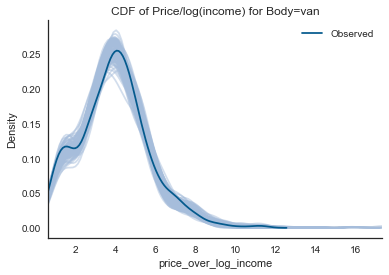

In [36]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(posterior_simulated_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(posterior_simulated_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    

From above, we see that we still have problems with the price variable. Try the piecewise linear specification of price AND the full set of interactions.

In [41]:
# np.random.seed(1152018)
# random_rows = np.random.choice(4000, size=500, replace=False)

# # Check the price variable for all of the various modes.
# for body in np.sort(car_df.body_type.unique()):
#     filter_row = car_df.body_type == body
    
#     current_title = 'Num Observations by Range for Body={}'
    
#     viz.plot_categorical_predictive_densities(
#         car_df,
#         None,
#         posterior_simulated_y[:, random_rows],
#         'range',
#         filter_row,
#         interaction_model_full.choices,
#         title=current_title.format(body))
    